#**(2) 바다나우 어텐션(Bahdanau Attention)**


##1. 바다나우 어텐션 함수(Bahdanau Attention Function)

**Attention(Q, K, V) = Attention Value**

t = 어텐션 메커니즘이 수행되는 디코더 셀의 현재 시점을 의미.


Q = Query : **t-1 시점**의 디코더 셀에서의 은닉 상태

K = Keys : 모든 시점의 인코더 셀의 은닉 상태들

V = Values : 모든 시점의 인코더 셀의 은닉 상태들

###**1) 어텐션 스코어(Attention Score)를 구한다.**

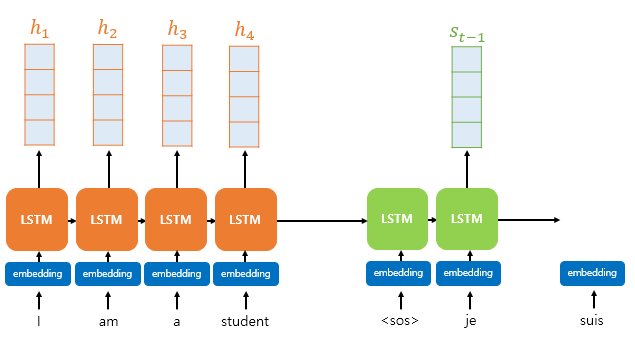

인코더의 시점(time step)을 각각 1 ~ N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h₁ ~ h**ₙ**

디코더의 현재 시점(time step) t에서 디코더의 은닉 상태(hidden state)를 s**ₜ**

인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정

위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4

루옹 어텐션에서는 Query로 디코더의 t 시점의 은닉 상태를 사용한 것과는 달리 이번에는 t-1 시점의 은닉 상태를 사용

바다나우 어텐션의 어텐션 스코어 함수. 즉, s**ₜ﹘₁**과 인코더의 i번째 은닉 상태의 어텐션 스코어 계산 방법은 아래와 같습니다.

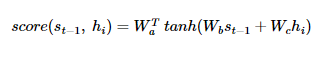

W는 학습 가능한 가중치 행렬

s**ₜ﹘₁**과  h₁~ h₄의 어텐션 스코어를 각각 구해야 하므로, 병렬 연산을 위해 h₁~ h₄를 하나의 행렬 H로 둡니다.



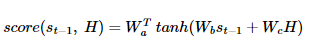

캡처.PNG

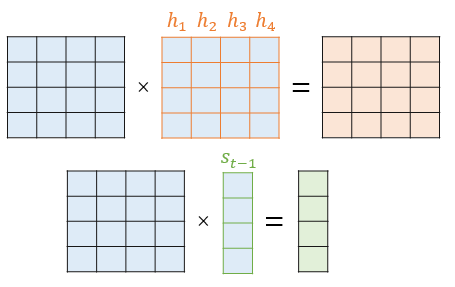

이 둘을 더한 후, 하이퍼볼릭탄젠트 함수를 지나도록 합니다.

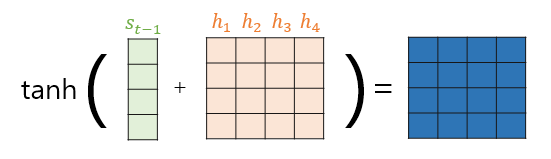

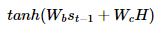

s**ₜ﹘₁**과  h₁~ h₄의 유사도가 기록된 어텐션 스코어 벡터 e^t를 얻습니다.

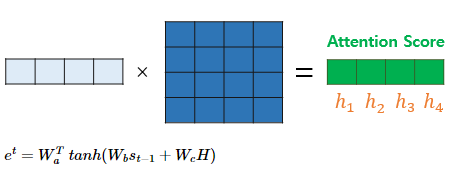

###**2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.**


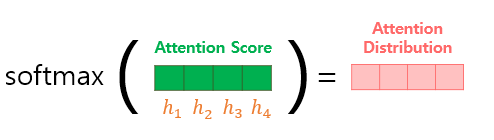

소프트맥스 함수를 적용하여 모든 값을 합하면 1이 되는 확률 분포 = 어텐션 분포(Attention Distribution)

각각의 값은 어텐션 가중치(Attention Weight) = 얼마만큼 우리가 Focus할 것인지

###**3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.**

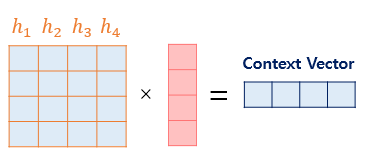

어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 

요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다.

 이 벡터는 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고 부릅니다.

###**4) 컨텍스트 벡터로부터 s**ₜ**를 구한다.**

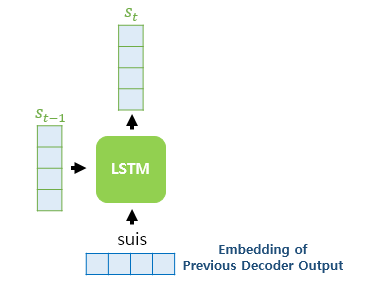

기존의 LSTM은 이전 시점의 셀로부터 전달받은 은닉 상태 
와 현재 시점의 입력 x**ₜ**를 가지고 연산하였습니다. 

해당 그림의 LSTM은 seq2seq의 디코더이며, 현재 시점의 입력 x**ₜ** 는 임베딩된 단어 벡터입니다.



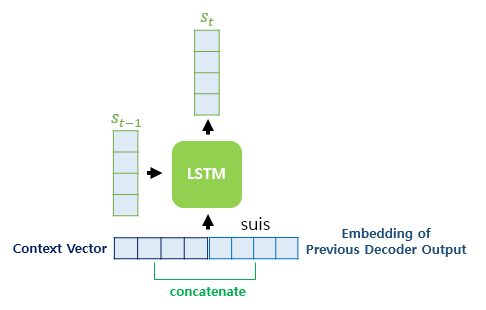

컨텍스트 벡터와 현재 시점의 입력인 단어의 임베딩 벡터를 연결(concatenate)하고, 현재 시점의 새로운 입력으로 사용하는 모습을 보여줍니다. 

그리고 이전 시점의 셀로부터 전달받은 은닉 상태 s**ₜ﹘₁** 
과 현재 시점의 새로운 입력으로부터 s**ₜ**
를 구합니다.

s**ₜ**는 출력층으로 전달되어 현재 시점의 예측값을 구한다.

이후 과정은 일반 LSTM과 동일

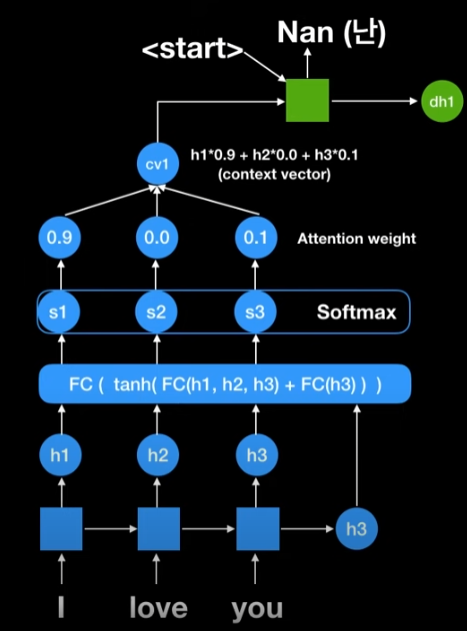

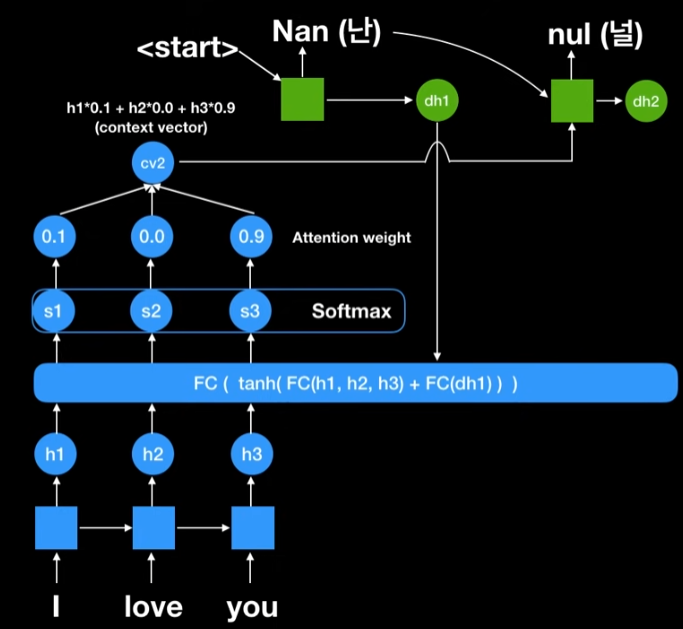

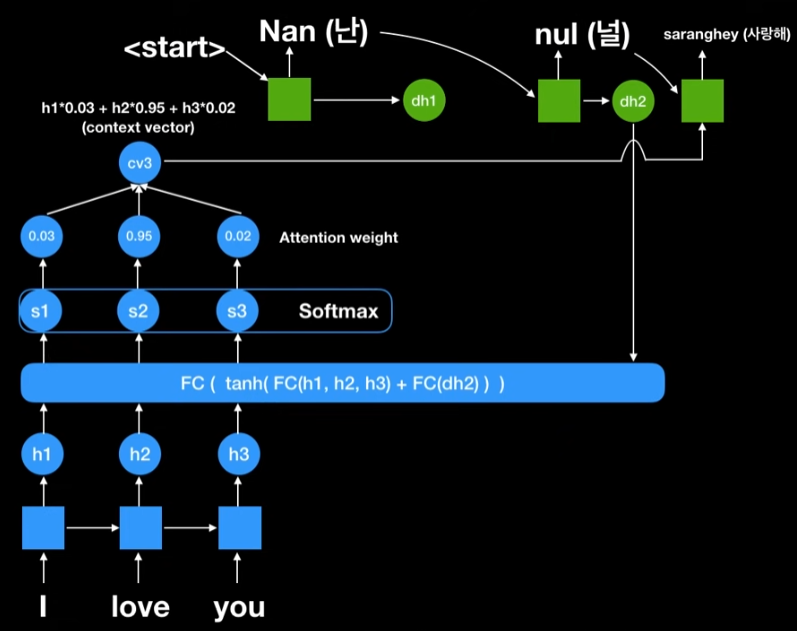

#**4) 양방향 LSTM과 어텐션 메커니즘(BiLSTM with Attention mechanism)**

##**1. IMDB 리뷰 데이터 전처리하기**

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

In [ ]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

In [ ]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

##**2. 바다나우 어텐션(Bahdanau Attention)**

In [ ]:
import tensorflow as tf

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
sequence_input = Input(shape=(max_len,), dtype='int32') #입력층
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input) #임베딩층

In [ ]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [ ]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [ ]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

In [ ]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [ ]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

출처 https://wikidocs.net/73161

https://wikidocs.net/48920

https://www.youtube.com/watch?v=WsQLdu2JMgI
